# Capstone Project: Train an AI Agent to Play Flappy Bird
## Introduction
The goal of this project is to understand and implement the process of training an AI agent to play the Flappy Bird game using computer vision and reinforcement learning.


## 1. Environment Setup
### Install necessary libraries


In [202]:
%cd PyGame-Learning-Environment

[WinError 2] The system cannot find the file specified: 'PyGame-Learning-Environment'
C:\Users\presc\OneDrive\Desktop\Computer Vision\Capstone Project\PyGame-Learning-Environment


### Set up the Flappy Bird environment using PyGame Learning Environment

In [205]:
class CustomFlappyEnv:
    def __init__(self, ple_env):
        self.env = ple_env
        self.reward_alive = 0.1
        self.reward_death = -5.0
        self.reward_pipe = 1.0

    def init(self):
        self.env.init()

    def reset_game(self):
        self.env.reset_game()

    def game_over(self):
        return self.env.game_over()

    def getScreenRGB(self):
        return self.env.getScreenRGB()

    def getActionSet(self):
        return self.env.getActionSet()

    def act(self, action):
        raw_reward = self.env.act(action)
        if self.env.game_over():
            return self.reward_death
        elif raw_reward > 0:  # Passed a pipe
            return self.reward_pipe
        else:
            return self.reward_alive


In [207]:
from ple.games.flappybird import FlappyBird
from ple import PLE

#Create the game
game = FlappyBird()
ple_env = PLE(
    game, 
    fps=30,
    display_screen=True,
    force_fps=True,
)
env = CustomFlappyEnv(ple_env)

#Initialize the environment
env.init()

#Get possible actions
action_set = env.getActionSet()
print("Available actions:", action_set)

Available actions: [119, None]


### Preprocessing function to resize and normalize game frames

In [210]:
def preprocess_frame(frame, size=(160, 160), grayscale=False, edge_detection=False):
    if grayscale or edge_detection:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    if edge_detection:
        frame = cv2.Canny(frame, threshold1=100, threshold2=200)

    frame = cv2.resize(frame, STATE_SIZE)
    frame = frame.astype(np.float32) / 255.0

    if grayscale or edge_detection:
        frame = np.expand_dims(frame, axis=-1)
    else:
        if frame.ndim == 2:
            frame = np.expand_dims(frame, axis=-1)  # failsafe
        elif frame.shape[-1] == 3:
            pass  # Already RGB
        else:
            raise ValueError("Unexpected frame shape:", frame.shape)
    return frame



## Pre-trained Model Integration
### Load a pre-trained model from Keras applications. The MobileNetV2 will be used due to it being less computationally demanding. To modify the MobileNetV2 model for feature extraction, I will remove three top layers that are used for classification. This way the model will only act as a feature extractor, providing high-level representation of the input image.

In [213]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (160, 160, 3)

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add custom dense layers for the Q-network
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer: Q-values for each action (using linear activation for regression)
output = Dense(2, activation='linear')(x)  # Linear activation for Q-values

# Final Q-network model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with an Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mean_squared_error',  # Correct loss function for Q-learning
    metrics=['accuracy'])

model.summary()


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape        ┃     Param # ┃ Connected to        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28        │ (None, 160, 160, 3) │           0 │ -                   │
│ (InputLayer)          │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ Conv1 (Conv2D)        │ (None, 80, 80, 32)  │         864 │ input_layer_28[0][… │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ bn_Conv1              │ (None, 80, 80, 32)  │         128 │ Conv1[0][0]         │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ Conv1_relu (ReLU)     │ (None, 80, 80, 32)  │           0 │ bn_Conv1[0][0]      │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ expanded_conv_depthw… │ (None, 80, 80, 32)  │         288 │ Conv1_relu[0][0]    │
│ (DepthwiseConv2D)     │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ expanded_conv_depthw… │ (None, 80, 80, 32)  │         128 │ expanded_conv_dept… │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ expanded_conv_depthw… │ (None, 80, 80, 32)  │           0 │ expanded_conv_dept… │
│ (ReLU)                │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ expanded_conv_project │ (None, 80, 80, 16)  │         512 │ expanded_conv_dept… │
│ (Conv2D)              │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ expanded_conv_projec… │ (None, 80, 80, 16)  │          64 │ expanded_conv_proj… │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_expand        │ (None, 80, 80, 96)  │       1,536 │ expanded_conv_proj… │
│ (Conv2D)              │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_expand_BN     │ (None, 80, 80, 96)  │         384 │ block_1_expand[0][… │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_expand_relu   │ (None, 80, 80, 96)  │           0 │ block_1_expand_BN[… │
│ (ReLU)                │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_pad           │ (None, 81, 81, 96)  │           0 │ block_1_expand_rel… │
│ (ZeroPadding2D)       │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_depthwise     │ (None, 40, 40, 96)  │         864 │ block_1_pad[0][0]   │
│ (DepthwiseConv2D)     │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_depthwise_BN  │ (None, 40, 40, 96)  │         384 │ block_1_depthwise[… │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ block_1_depthwise_re… │ (None, 40, 40, 96)  │           0 │ block_1_depthwise_… │
│ (ReLU)                │                     │     

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Reinforcement Learning Implementation
### Immplement the DQNAgent class with the init, build_model, remember, act, and replay methods.

In [216]:
import random
from collections import deque
import numpy as np

class DQNAgent:
    def __init__(self,
                 state_shape=(160, 160, 1),
                 action_size=2,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_min=0.1,
                 epsilon_decay=0.995,
                 learning_rate=1e-4,
                 memory_size=5000,
                 batch_size=64,
                 target_update_freq=50):
        self.state_shape = state_shape
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.train_step = 0

        # Experience Replay
        self.memory = deque(maxlen=memory_size)

        # Build main and target Q-networks
        self.model = self.build_model()
        self.target_model = clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())  # Sync weights

    def build_model(self):
        """Create a Q-network with a MobileNetV2 backbone."""
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.state_shape)
        base_model.trainable = False  # Use frozen base for speed & stability

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(self.action_size, activation='linear')(x)  # Linear output for Q-values

        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        """Store a transition in the replay buffer."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Choose an action using epsilon-greedy strategy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])

    def update_target_network(self):
        """Copy weights from the main model to the target model."""
        self.target_model.set_weights(self.model.get_weights())
        print(f"[Target Network Updated] Step: {self.train_step}")

    def replay(self):
        """Train the Q-network using experience replay."""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, targets = [], []

        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]

            if done:
                target[action] = reward
            else:
                # Use target network to predict future Q-values
                future_q = self.target_model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0]
                target[action] = reward + self.gamma * np.max(future_q)

            states.append(state)
            targets.append(target)

        states = np.array(states)
        targets = np.array(targets)

        # Train on the batch
        self.model.fit(states, targets, verbose=0, batch_size=self.batch_size)

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network periodically
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.update_target_network()

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)  # A deque for efficient pops from the front
        self.batch_size = batch_size

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self):
        return random.sample(self.buffer, self.batch_size)

    def size(self):
        return len(self.buffer)

    def is_full(self):
        return len(self.buffer) == self.buffer.maxlen


## Model Training
### Setting up the training loop to interact with the Flappy Bird environment.


*   Implement frame skipping for efficiency.
*   Store experiences and perform learning steps.
*   Periodically update the target network.
*   Implement a decay schedule for the exploration rate.



In [219]:
import cv2
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras

FRAME_SKIP = 8
FRAME_STACK_SIZE = 4
STATE_SIZE = (160, 160)
SAVE_EVERY = 25
CHECKPOINT_DIR = 'checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Agent Initialization
agent = DQNAgent(
    state_shape=(160, 160, 3),
    action_size=len(action_set)
)

use_grayscale = True
use_edge_detection = True

# Initialize with proper shape
if use_grayscale or use_edge_detection:
    channel_count = 1
else:
    channel_count = 3

# Replay buffer initialization
replay_buffer_size = 50000  # You can adjust this size
replay_buffer = deque(maxlen=replay_buffer_size)

# Training Parameters
EPISODES = 500
reward_history = []
steps_history = []
best_reward = float('-inf')

# Training Loop
for episode in range(1, EPISODES + 1):
    env.reset_game()
    done = env.game_over()
    state_raw = env.getScreenRGB()
    state = preprocess_frame(state_raw)
    total_reward = 0
    steps = 0

    # Initialize frame stack with 4 empty frames (or first frames)
    frame_stack = [np.zeros((*STATE_SIZE, channel_count), dtype=np.float32) for _ in range(FRAME_STACK_SIZE)]

    while not env.game_over():
        action_idx = agent.act(state)
        action = action_set[action_idx]
        cumulative_reward = 0

        for _ in range(FRAME_SKIP):
            reward = env.act(action)
            cumulative_reward += reward
            if env.game_over():
                break

        next_state_raw = env.getScreenRGB()
        next_state = preprocess_frame(next_state_raw)

        # Add the next state to the frame stack
        frame_stack.append(next_state)  # Add current frame
        frame_stack.pop(0)  # Remove the oldest frame

        if done:
            break

        # Concatenate the last 4 frames to form the state input
        stacked_state = np.concatenate(frame_stack, axis=-1)  # Shape: (160, 160, 4)

        agent.remember(state, action_idx, cumulative_reward, next_state, done)
        agent.replay()
        
        state = next_state
        total_reward += cumulative_reward
        steps += 1

    # ✅ Save total reward to history
    reward_history.append(total_reward)
    steps_history.append(steps)

     # 🖨️ Episode summary
    avg_reward = np.mean(reward_history[-10:])
    avg_steps = np.mean(steps_history[-10:])
    print(f"Episode {episode:03d} | Reward: {total_reward:.2f} | Steps: {steps} | "
          f"Epsilon: {agent.epsilon:.3f} | AvgReward(10): {avg_reward:.2f} | AvgSteps(10): {avg_steps:.2f}")
    
    # 🏅 Save best model
    if total_reward > best_reward:
        best_reward = total_reward
        best_path = os.path.join(CHECKPOINT_DIR, 'best_model.keras')
        agent.model.save(best_path)
        print(f"🏅 Best model saved with reward: {best_reward:.2f}")

    # ✅ Save regular checkpoints
    if episode % SAVE_EVERY == 100:
        model_path = os.path.join(CHECKPOINT_DIR, f'dqn_flappy_episode_{episode}.keras')
        agent.model.save(model_path)
        print(f"✅ Model saved: {model_path}")


Episode 001 | Reward: 0.50 | Steps: 7 | Epsilon: 1.000 | AvgReward(10): 0.50 | AvgSteps(10): 7.00
🏅 Best model saved with reward: 0.50
Episode 002 | Reward: 1.10 | Steps: 8 | Epsilon: 1.000 | AvgReward(10): 0.80 | AvgSteps(10): 7.50
🏅 Best model saved with reward: 1.10
Episode 003 | Reward: 1.10 | Steps: 8 | Epsilon: 1.000 | AvgReward(10): 0.90 | AvgSteps(10): 7.67
Episode 004 | Reward: -0.50 | Steps: 6 | Epsilon: 1.000 | AvgReward(10): 0.55 | AvgSteps(10): 7.25
Episode 005 | Reward: 1.10 | Steps: 8 | Epsilon: 1.000 | AvgReward(10): 0.66 | AvgSteps(10): 7.40
Episode 006 | Reward: 1.10 | Steps: 8 | Epsilon: 1.000 | AvgReward(10): 0.73 | AvgSteps(10): 7.50
Episode 007 | Reward: 5.60 | Steps: 13 | Epsilon: 1.000 | AvgReward(10): 1.43 | AvgSteps(10): 8.29
🏅 Best model saved with reward: 5.60
Episode 008 | Reward: 2.60 | Steps: 9 | Epsilon: 0.980 | AvgReward(10): 1.57 | AvgSteps(10): 8.38
Episode 009 | Reward: -0.60 | Steps: 6 | Epsilon: 0.951 | AvgReward(10): 1.33 | AvgSteps(10): 8.11
Epis

## Testing and Evaluation

*   Implement a separate testing script to evaluate the trained agent.
*   Record metrics such as average score and survival time.
*   Visualize the agent's performance using matplotlib or a similar library.



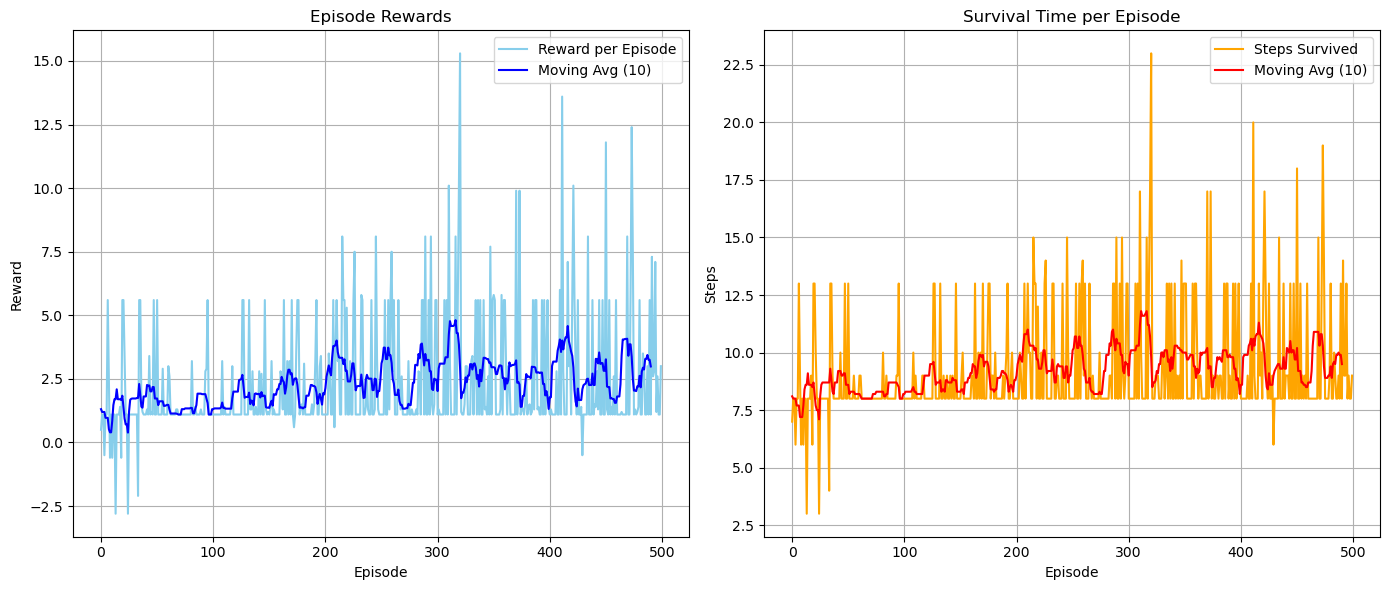

In [221]:
# Moving average helper ---
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# --- Plotting ---
plt.figure(figsize=(14, 6))

# 🎯 Rewards Plot
plt.subplot(1, 2, 1)
plt.plot(reward_history, label='Reward per Episode', color='skyblue')
plt.plot(moving_average(reward_history), label='Moving Avg (10)', color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards')
plt.legend()
plt.grid(True)

# ⏱️ Steps/Survival Plot
plt.subplot(1, 2, 2)
plt.plot(steps_history, label='Steps Survived', color='orange')
plt.plot(moving_average(steps_history), label='Moving Avg (10)', color='red')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Survival Time per Episode')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('agent_training_metrics.png')
plt.show()
